In [25]:
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

In [26]:
regions = [[np.arange(201, dtype='float64')*0.01 + 6301.0, None]]
lines   = [6301, 6302]

In [27]:
me = MilneEddington.MilneEddington(regions, lines, nthreads=2)

pyMilne::dealloc: cleaning-up...


In [28]:
param = ['|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1']
m_in = np.float64([1000., 1.0, 0.39, 0.1, 0.02, 30., 0.1, 0.2, 0.8])
ny = 1
nx = 2
model = me.repeat_model(m_in, ny, nx)
syn, rf = me.synthesize_rf(model, mu = 1.0)

noise_level = 1.e-2
syn += np.random.normal(loc = 0.0, scale=noise_level, size = syn.shape)
sig = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
sig += noise_level

In [29]:
ll = np.squeeze(regions[0])
ll = ll[0]

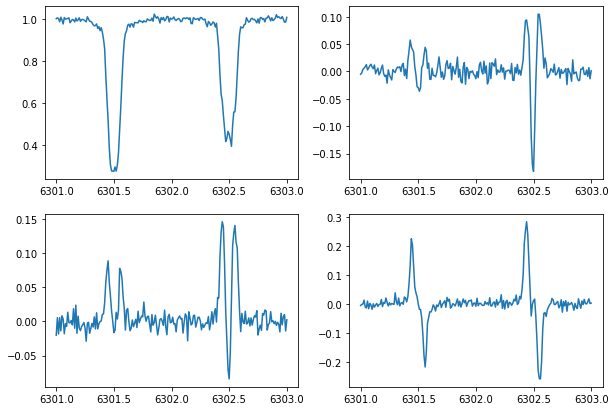

In [30]:
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,syn[0,0,0])
plt.subplot(222)
plt.plot(ll,syn[0,0,1])
plt.subplot(223)
plt.plot(ll,syn[0,0,2])
plt.subplot(224)
plt.plot(ll,syn[0,0,3])

In [31]:
# We can tune the weight of Q,U and V by lowering their noise estimate
sig[1:3] /= 7.
sig[3]   /= 3.
    
#
# provide initial model with different parameters than the ones used in the synthesis
#
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, ny, nx)

    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, syn, sig, nRandom = 5, nIter=20, chi2_thres=1.0, verbose=False)

#
# Estimate uncertainties of the results
#
errors = me.estimate_uncertainties(model_out, syn, sig, mu=1.0)
#
# Print obtained parameters and compare with the original ones
#
print('Real parameters -----> Inverted values +/- uncertainty')
for ii in range(9):
    print(f'{param[ii]:15}','{0:13.5f} -----> {1:13.5f} +/- {2:8.5f}'.format(m_in[ii], model_out[0,0,ii], errors[0,0,ii]))

Real parameters -----> Inverted values +/- uncertainty
|B| [G]            1000.00000 ----->    1007.90716 +/- 85.31086
inc [rad]             1.00000 ----->       1.00621 +/-  0.09256
azi [rad]             0.39000 ----->       0.38578 +/-  0.08430
vlos [km/s]           0.10000 ----->       0.09985 +/-  0.14246
vDop [Angstrom]       0.02000 ----->       0.02005 +/-  0.00192
eta_l                30.00000 ----->      30.54239 +/- 13.15368
damping               0.10000 ----->       0.09680 +/-  0.07638
S0                    0.20000 ----->       0.19769 +/-  0.05115
S1                    0.80000 ----->       0.80296 +/-  0.05027


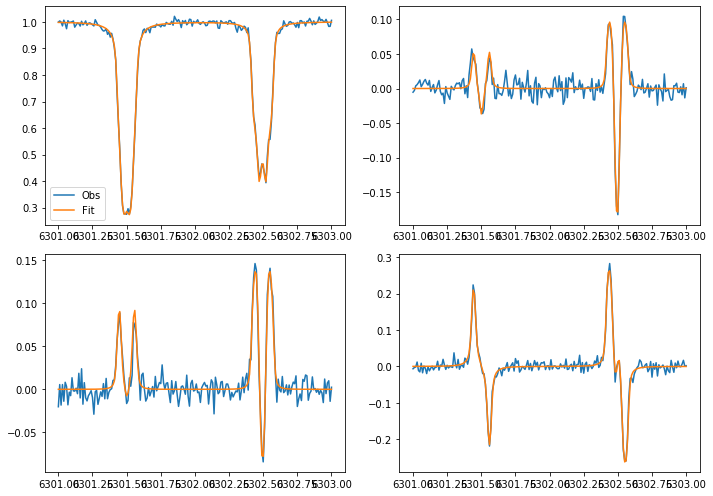

In [32]:
#Let's plot our fake observations and the fit:
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,syn[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.legend()
plt.subplot(222)
plt.plot(ll,syn[0,0,1])
plt.plot(ll,syn_out[0,0,1])
plt.subplot(223)
plt.plot(ll,syn[0,0,2])
plt.plot(ll,syn_out[0,0,2])
plt.subplot(224)
plt.plot(ll,syn[0,0,3])
plt.plot(ll,syn_out[0,0,3])
plt.tight_layout()